## Pregunta 1: Ayudantía 8 Diseño de Reactores 2025

Para abrir en Google Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/SysBioengLab/IIQ2113-Chemical-reactor-design/blob/main/Ayudantias/Ayudantia_8_DdR.ipynb)

Acá importamos los paquetes para usar! Numpy para operaciones numéricas, solve_ivp para resolver ecuaciones diferenciales, fsolve para resolver ecuaciones no lineales y matplotlib para graficar.

In [21]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

Aquí anotamos los parámetros del enunciado, las constantes cinéticas, los volúmenes de los reactores, el caudal de alimentación y las concentraciones de entrada.

In [22]:
k1, k2 = 10, 20             # [L/mol s] (constantes de velocidad de reacción)
V1, V2 = 300, 100           # [L] (volúmen del CSTR y del PFR)
v0 = 10                     # [L/s] (caudal de alimentación del sistema)
C0 = np.array([1, 1, 0, 0]) # [mol/L]  (concentraciones de entrada de A, B, C y D respectivamente)

Aquí definimos dos funciones, una que calcule la velocidad de reacción en base a la concentración y otra que represente la ecuación diferencial del PFR.

In [23]:
# Velocidades de reacción (reacciones elementales e irreversibles)
def rates(C,args): # C es el vector de concentraciones [A, B, C, D] donde se está evaluando la velocidad
    A, B, Cc, D = C
    k1, k2 = args
    rA = -k1*A*B - k2*A*Cc # velocidad de A
    rB = -k1*A*B # velocidad de B
    rC =  k1*A*B - k2*A*Cc # velocidad de C
    rD =  k2*A*Cc # velocidad de D
    return np.array([rA, rB, rC, rD])
# Ecuaciones diferenciales del PFR: dC/dV = r/v
def pfr_odes(V, C, args):
    k1, k2, v3 = args
    return rates(C,args = [k1,k2])/v3 # v3 es el caudal en la entrada del PFR, y estamos asumiendo que se mantiene en todo el PFR, es decir, su area transversal es constante y esta en estado estacionario
# v1(C1 - C2) + V1*r(C2) = 0  (ecuación de diseño CSTR)
def fCSTR(C2,args):
    C1, v1, V1, k1, k2 = args
    return v1*(C1 - C2) + V1*rates(C2,args= [k1, k2]) # Ecuación de diseño del CSTR

Aquí establecemos el bucle que va resolviendo iterativamente para cada flujo de recirculación.

In [24]:
vR_values = np.linspace(0, 200, 100) # [L/s] valores de caudal de recirculación a evaluar
Cout_C = []  # vector para guardar la concentración de C en la corriente final
for vR in vR_values:
    # 1. MEZCLA
    # v0*C0 + vR*CR = v1*C1
    v1 = v0 + vR # [L/s] (caudal de entrada al CSTR)
    CR = np.zeros(4)  # Corriente reciclada inicial (C_A,R, C_B,R, C_C,R, C_D,R) (partimos suponiendo que no entra ninguna especie reciclada)
    err = False #variable para el criterio de convergencia del while
    while not err:
        C1 = (v0*C0 + vR*CR) / v1 # Concentración en la mezcla, despejada del balance de masa
        # 2. CSTR
        C2 = fsolve(fCSTR,C1,args=[C1,v1,V1,k1,k2]) #fsolve resuelve el sistema de ecuaciones no lineales del CSTR
        # 3. PFR
        # dC/dV = r(C)/v3 ,  C(V=0)=C2 ,  C(V=V2)=C3
        sol = solve_ivp(pfr_odes, [0, V2], C2, args=([k1, k2, v1],)) # Resuelve las ODEs del PFR
        C3 = sol.y[:, -1] # Concentración a la salida del PFR
        # 4. SEPARADOR
        # v3*C3 = v4*C4 + vR*CR
        #  con fracciones:
        #   0.9·v3·C_A,3 = vR·C_A,R
        #   1.0·v3·C_B,3 = vR·C_B,R
        #   0.5·v3·C_C,3 = vR·C_C,R
        #   0.0·v3·C_D,3 = vR·C_D,R
        CA_R = 0.9*C3[0]   # 90% de A recircula
        CB_R = 1.0*C3[1]   # 100% de B recircula
        CC_R = 0.5*C3[2]   # 50% de C recircula
        CD_R = 0.0*C3[3]   # D no se recircula
        CR_new = np.array([CA_R, CB_R, CC_R, CD_R])
        # Corriente de salida (producto, no reciclada)
        # v4*C4 = v3*C3 - vR*CR  →  C4 = ((v3*C3)-(vR*CR))/v4
        v3 = v1
        v4 = v3 - vR
        C4 = ((v3*C3) - (vR*CR_new)) / v4 # Concentración en la salida, despejada del balance de masa
        # Criterio de convergencia
        err = np.allclose(CR_new,CR) # Compara si CR_new y CR son "suficientemente" cercanas
        CR = CR_new.copy() # Actualizamos CR para la siguiente iteración del while
    # Guardar concentración de C en la corriente final
    Cout_C.append(C4[2])

Aquí viene el gráfico de la concentración versus el flujo de recirculación. vemos que, al menos en el intervalo que probamos, la concentración de salida aumenta monotónicamente con el flujo de recirculación. Esto implicaría que, a mayor recirculación, siempre obtendremos una concentración mayor de producto. En teoría, esto es muy prometedor, pero hay que recordar que cada litro que recirculemos es un litro más que debe ser movilizado por bombas en el sistema, es decir, tiene su propio costo asociado.

Caudal de recirculación óptimo = 200.000 L/s


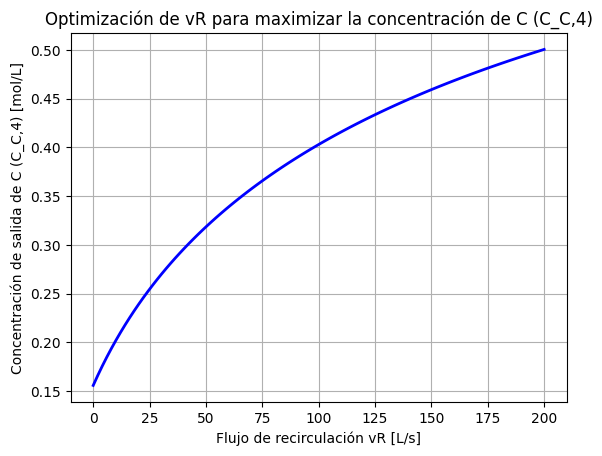

In [25]:
vR_opt = vR_values[np.argmax(Cout_C)]
print(f"Caudal de recirculación óptimo = {vR_opt:.3f} L/s")
plt.plot(vR_values, Cout_C, 'b', lw=2)
plt.xlabel("Flujo de recirculación vR [L/s]")
plt.ylabel("Concentración de salida de C (C_C,4) [mol/L]")
plt.title("Optimización de vR para maximizar la concentración de C (C_C,4)")
plt.grid(True)
plt.show()

## Pregunta 2: Ayudantía 8 DdR 2025

Importamos los paquetes necesarios (numpy para operaciones, matplotlib para graficar).

In [26]:
import numpy as np
import matplotlib.pyplot as plt

Luego de que, en papel, lográramos sacar las curvas E(t) para cada patrón de flujo en el reactor, ahora los comparamos con las contrapartes ideales. Para esto, definimos los parámetros relevantes para graficar y las funciones E(t).

In [27]:
t_min = 10.0 # Enunciado, 10 minutos como tiempo de residencia mínimo de referencia para la comparación
tau_lam = 2 * t_min # Enunciado, tiempo de residencia promedio para flujo laminar
tau_turb = 1.24 * t_min # Enunciado, tiempo de residencia promedio para flujo turbulento
B = 0.404 # Valor de la función Beta usada en flujo turbulento.
# Definiciones de E(t)
def E_laminar(t, t_min):
    E = np.zeros_like(t)
    mask = t >= t_min
    E[mask] = 2 * (t_min ** 2) / (t[mask] ** 3) # para t >= t_min, es la función que demostramos
    return E
def E_turbulento(t, t_min, B):
    E = np.zeros_like(t)
    mask = t >= t_min # para t >= t_min
    E[mask] = (7 / (B * t_min)) * (1 - (t_min / t[mask]) ** 7) * (t_min / t[mask]) ** 9 # función que demostramos a mano
    return E
def E_CSTR(t, tau):
    E = np.zeros_like(t)
    mask = t >= 0
    E[mask] = (1 / tau) * np.exp(-t[mask] / tau) # Función E(t) para CSTR ideal, sacado de clases
    return E
# No es necesario definir E_PFR, ya que es un peak en t = tau.
t = np.linspace(0, 100, 1000)

Evaluamos en el intervalo donde queremos graficar las funciones E(t)

In [28]:
E_lam = E_laminar(t, t_min)
E_turb = E_turbulento(t, t_min, B)
E_cstr_lam = E_CSTR(t, tau_lam)
E_cstr_turb = E_CSTR(t, tau_turb)

Graficamos para el caso laminar

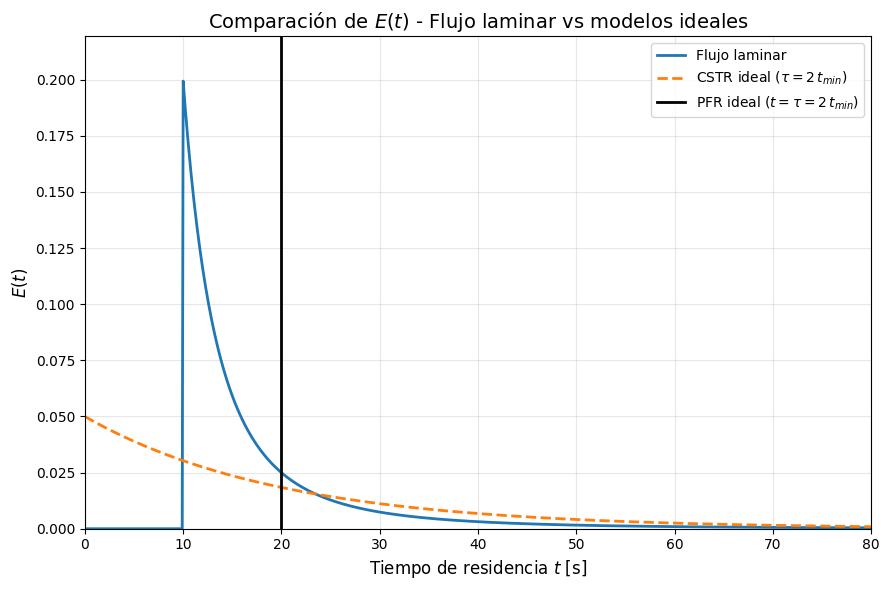

In [29]:
plt.figure(figsize=(9,6))
plt.plot(t, E_lam, label=r'Flujo laminar', lw=2, color='C0')
plt.plot(t, E_cstr_lam, '--', color='C1', lw=2, label=r'CSTR ideal ($\tau = 2\,t_{min}$)')
plt.axvline(x=tau_lam, color='k', lw=2, label=r'PFR ideal ($t=\tau=2\,t_{min}$)')
ymax = 1.1 * max(E_lam.max(), E_cstr_lam.max())
plt.ylim(0, ymax)
plt.xlim(0, 80)
plt.xlabel(r'Tiempo de residencia $t$ [s]', fontsize=12)
plt.ylabel(r'$E(t)$', fontsize=12)
plt.title('Comparación de $E(t)$ - Flujo laminar vs modelos ideales', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Comportamiento intermedio entre CSTR y PFR, pues muestra un decaimiento similar al exponencial luego de su tiempo de residencia mínimo.

Graficamos para el caso turbulento

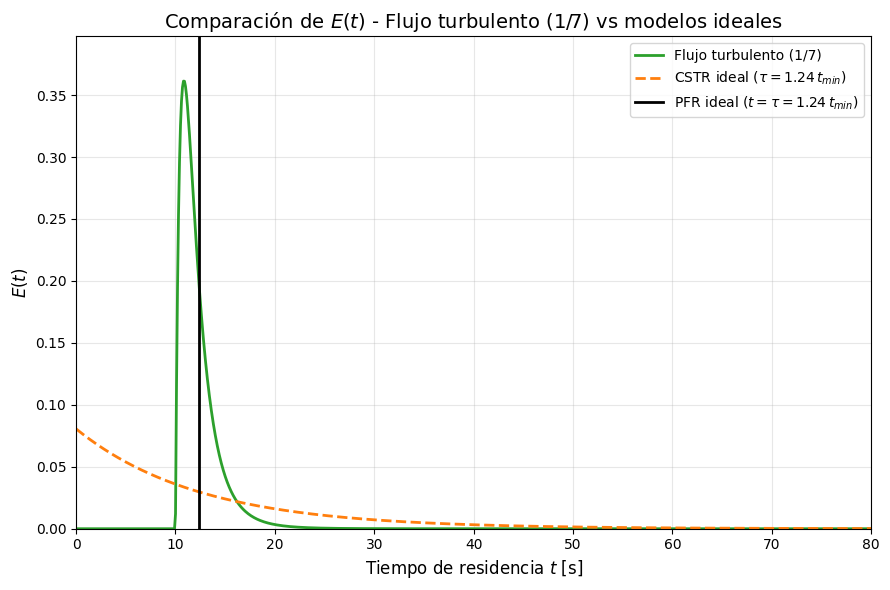

In [30]:
plt.figure(figsize=(9,6))
plt.plot(t, E_turb, label=r'Flujo turbulento (1/7)', lw=2, color='C2')
plt.plot(t, E_cstr_turb, '--', color='C1', lw=2, label=r'CSTR ideal ($\tau = 1.24\,t_{min}$)')
plt.axvline(x=tau_turb, color='k', lw=2, label=r'PFR ideal ($t=\tau=1.24\,t_{min}$)')
ymax = 1.1 * max(E_turb.max(), E_cstr_turb.max())
plt.ylim(0, ymax)
plt.xlim(0, 80)
plt.xlabel(r'Tiempo de residencia $t$ [s]', fontsize=12)
plt.ylabel(r'$E(t)$', fontsize=12)
plt.title('Comparación de $E(t)$ - Flujo turbulento (1/7) vs modelos ideales', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Comportamiento muy similar al PFR, casi un pulso unitario, tiene un poco de delay. Tiene sentido pensando en la gráfica del flujo turbulento, es similar al flujo pistón.

## Pregunta 3: Ayudantía 8 Diseño de Reactores 2025

Los cálculos se pueden realizar directamente en el papel o en el código. Aquí les mostraré la implementación completa. Partamos cargando la información del enunciado y los paquetes relevantes:

In [31]:
import numpy as np
import matplotlib.pyplot as plt
t = [0,1,2,3,4,5,6,7,8,9,10] # tiempo en minutos
C_t = [0,40,75,120,200,350,500,400,280,120,0] # Concentración de trazador a la salida, en mol/m^3
v0 = 1/60 # Caudal de alimentación en m^3/min

Para obtener el pulso de trazador, "integramos" (sumamos) el área bajo la curva C y multiplicamos por el caudal, en unidades consistentes.

In [32]:
pulso = v0 * sum(C_t[i]*(t[i]-t[i-1]) for i in range(1,len(t)))
print(f"El pulso de trazador es de {pulso:.2f} mol")

El pulso de trazador es de 34.75 mol


Ahora, para obtener el tiempo medio de residencia, "integramos" (sumamos) nuevamente, pero ahora además el área bajo la curva ponderada por el tiempo (t $\cdot$ C)

In [33]:
tiempo_medio = sum(t[i]*C_t[i]*(t[i]-t[i-1]) for i in range(1,len(t))) / sum(C_t[i]*(t[i]-t[i-1]) for i in range(1,len(t)))
print(f"El tiempo medio de residencia es de {tiempo_medio:.3f} minutos")

El tiempo medio de residencia es de 5.861 minutos


El caso de la curva E es simple, solamente dividimos el vector de concentraciones por el área que "integramos" (sumamos)

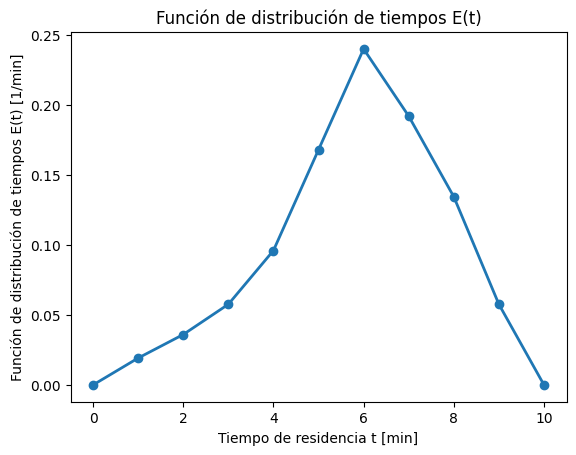

In [34]:
E = C_t
suma = sum(C_t[i]*(t[i]-t[i-1]) for i in range(1,len(t)))
for i in range(1, len(t)):
    E[i] = C_t[i] / suma
plt.plot(t, E, 'o-', lw=2)
plt.xlabel("Tiempo de residencia t [min]")
plt.ylabel("Función de distribución de tiempos E(t) [1/min]")
plt.title("Función de distribución de tiempos E(t)");

Para la curva F, consideremos que esta es como la versión "acumulada" de la curva E. Es decir, vamos "sumando" a lo que ya ocurrió (en este caso, a la salida de trazador del sistema). Considerando que ya tenemos la curva E, es fácil calcularla a partir de esta.

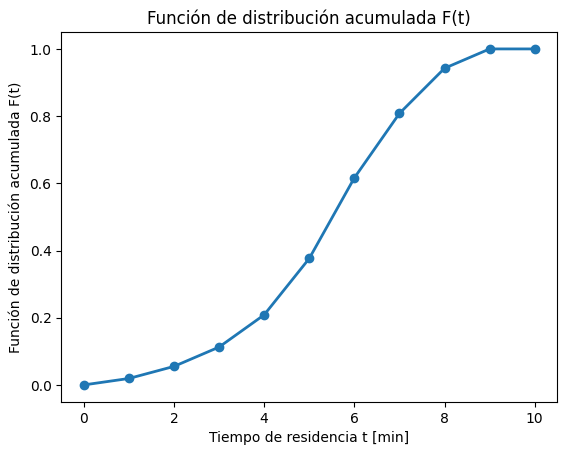

In [35]:
F = [0]*len(t)
for i in range(1, len(t)):
    subtotal = 0
    for j in range(1, i+1):
        subtotal += E[j] * (t[j] - t[j-1])
    F[i] = subtotal
plt.figure()
plt.plot(t, F, 'o-', lw=2)
plt.xlabel("Tiempo de residencia t [min]")
plt.ylabel("Función de distribución acumulada F(t)")
plt.title("Función de distribución acumulada F(t)");
